In [5]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [37]:
# Defining the ODE function

def dinner_odes(X, t, params):
    r, L = X

    gamma_n, k_n, eta_L, eta_r, P, R0 = params

    h = 3 * 10**(-3)
    mu_L = 1 / (2 * np.pi * h * eta_L)
    mu_r = 1 / (2 * np.pi * h * eta_r)

    gamma = gamma_n * (P * R0)
    k = k_n * P * R0**3

    U = -P * np.pi * (r**2) + 2 * np.pi * gamma * r + k * np.pi * r * (1 / r - 1 / R0)**2
    dUdr = -2 * P * np.pi * r + 2 * np.pi * gamma - k * np.pi * (1 / (r**2) - 1 / (R0**2))
    kappa = -mu_L * U / r

    dLdt = L * kappa
    drdt = -mu_r * r * dUdr

    return [drdt, dLdt]


<h3> Sensitivity Analysis </h3>

How is the log growth rate of width determined by the bending rigidity and surface tension of the cell? 

Steps: 
1. Fit the width to a logistic function and get the r from there
2.  Vary k_n and gamma_n in a 2D plane and plot the r values for each fit on the color axis

In [102]:
# Setting the parameters: 
eta_L = 696.5
eta_r = 995.3
P = 0.7
R0 = 0.3
# Set initial conditions and parameters
X0 = [0.3, 3]  # Assuming avg_width and avg_length are defined
tspan = np.linspace(0, 25, 200)  # Define the time span

# Define the logistic function
def logistic_function(t, w_min, w_max, r):
    w = (w_min*w_max)/(w_min + (w_max-w_min)*np.exp(-r*t))
    return w


In [ ]:

plt.figure(figsize=[60,60])
i=0
for gamma_n in np.arange(0.99, 0.01, -0.1):
    for k_n in np.arange(2.5, 11, 0.85):
        i = i+1
        opt_params = [gamma_n, k_n, eta_L, eta_r, P, R0]
        # Solve the ODEs
        sol = odeint(dinner_odes, X0, tspan, args=(opt_params,))
        # The solution 'sol' contains the values of r and L over time
        # You can access them using sol[:, 0] for r and sol[:, 1] for L
        # Fitting the logistic function 
        # Generate some example data
        x_data = tspan
        y_data = sol[:,0]

        # Use curve_fit to fit the logistic function to the data
        params, covariance = curve_fit(logistic_function, x_data, y_data)

        # Extract the parameters
        w_min_fit, w_max_fit, r_fit = params

        # Generate a finer x range for plotting the fitted curve
        x_fit = np.linspace(min(x_data), max(x_data), 1000)
        y_fit = logistic_function(x_fit, w_min_fit, w_max_fit, r_fit)

        # Plot the original data and the fitted logistic curve
        plt.subplot(10,10,i)
        plt.scatter(x_data, y_data, 5, label='Model ODE solution')
        plt.plot(x_fit, y_fit, label='Fitted Logistic Curve', color='red')
        # plt.legend()
        # plt.ylim(0.3,0.4)
        plt.xlabel(f'w_mn = {w_min_fit:.4f}, w_mx = {w_max_fit:.4f},r = {r_fit:.4f}')
        # plt.ylabel('y')
        plt.title(f'k_n = {k_n:0.2f}, gamma_n = {gamma_n:.2f}')
        # plt.show()
        # print('fit parameters: ')
        # print(f'r = {r_fit:.4f}\nw_max = {w_max_fit:.4f}\nw_min = {w_min_fit:.4f}')

In [103]:
def find_r(gamma_n, k_n):
    # Setting the parameters: 
    eta_L = 696.5
    eta_r = 995.3
    P = 0.7
    R0 = 0.3
    opt_params = [gamma_n, k_n, eta_L, eta_r, P, R0]
    # Solve the ODEs
    sol = odeint(dinner_odes, X0, tspan, args=(opt_params,))
    # The solution 'sol' contains the values of r and L over time
    # You can access them using sol[:, 0] for r and sol[:, 1] for L
    # Fitting the logistic function 
    # Generate some example data
    x_data = tspan
    y_data = sol[:,0]

    # Use curve_fit to fit the logistic function to the data
    params, covariance = curve_fit(logistic_function, x_data, y_data)

    # Extract the parameters
    w_min_fit, w_max_fit, r_fit = params
    return r_fit
        

In [108]:
find_r(0.4, 4.6)

0.1639391657652898

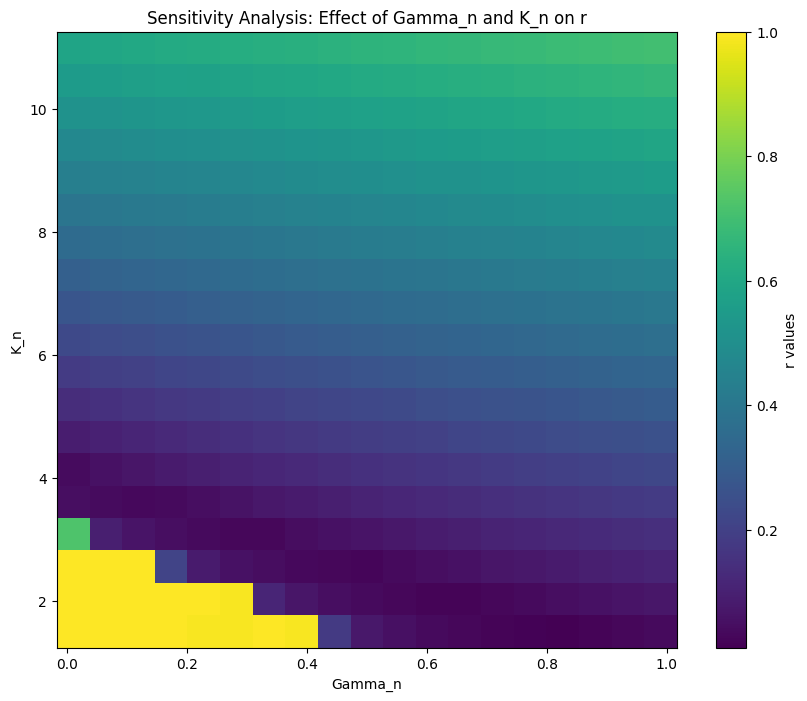

In [131]:
g_n = np.linspace(0.01,0.99,19)
k_n = np.linspace(1.5, 11, 19)

G,K = np.meshgrid(g_n, k_n)
find_r_vec = np.vectorize(find_r)

# Calculate R values for each combination of G and K
R = find_r_vec(G, K)


#Plot the results
plt.figure(figsize=[10, 8])
plt.pcolormesh(G, K, R, cmap='viridis')
plt.colorbar(label='r values')
plt.xlabel('Gamma_n')
plt.ylabel('K_n')
plt.title('Sensitivity Analysis: Effect of Gamma_n and K_n on r')
plt.show()